# Oral Cancer Classification using CNN and Transfer Learning

## Project Summary
This notebook demonstrates the classification of Oral Cancer images into four categories:
- **Oral Normal** and **Oral Scc**

The project includes:
1. Custom CNN model architecture
2. Transfer learning with VGG16, ResNet50, EfficientNetB0, and MobileNetV2
3. Data preprocessing and augmentation
4. Model training with validation
5. Performance evaluation using accuracy and loss curves

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('//kaggle/input/oral-cancer/Oral Cancer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0771.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0707.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3093.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0480.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0654.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0620.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3567.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_1208.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_0761.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_2566.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_1952.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_4835.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3963.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_3084.jpg
//kaggle/input/oral-cancer/Oral Cancer/oral_scc/oral_scc_1822.jpg
//kaggle/i

## 1. Import Required Libraries
This section loads all required Python libraries. These include TensorFlow and Keras for deep learning, NumPy for numerical operations, Matplotlib for plotting results, and OS for path handling.

In [2]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-geli_496
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-geli_496
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import os
from tqdm import tqdm 

## 2. Load and Prepare the Dataset
We use `ImageDataGenerator` from Keras to:
- Normalize images (rescale pixel values to [0, 1])
- Resize them to a fixed dimension
- Perform a training-validation split

This preprocessing helps models train more efficiently.

In [5]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root="/kaggle/input/oral-cancer/Oral Cancer", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 3. Visualize Dataset
Here, we can display a few random images from each class (Oral_normal and Oral_scc). This is a useful sanity check to ensure:
- Images are loading properly
- Labels are correct
- Data distribution appears reasonable

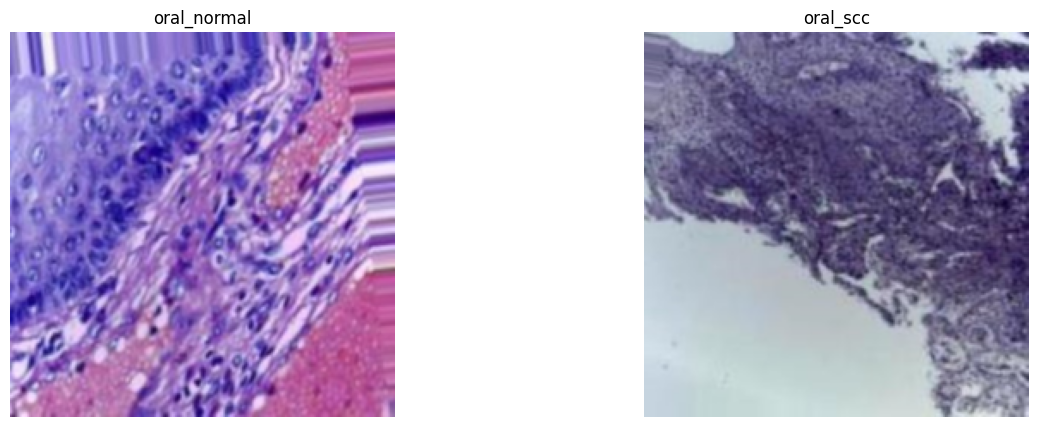

In [6]:
class_names = dataset.classes
num_classes = len(class_names)

fig, axs = plt.subplots(1, num_classes, figsize=(15, 5))

displayed_classes = {class_name: False for class_name in class_names}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        if not displayed_classes[class_name]:
            img = img.permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5 
            axs[label].imshow(np.clip(img, 0, 1)) 
            axs[label].set_title(class_name)
            axs[label].axis('off')
            displayed_classes[class_name] = True  

        if all(displayed_classes.values()):
            break

    if all(displayed_classes.values()):
        break

plt.show()


## 4. Define Custom CNN Model
This section defines a convolutional neural network from scratch using Keras. The architecture includes:
- Convolution and MaxPooling layers to extract features
- Dropout layers to reduce overfitting
- Dense layers for final classification

In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## 5.Train the Model with Early Stopping
We train the custom CNN model using:
- **Adam** optimizer
- **Categorical crossentropy** as the loss function
- **EarlyStopping** callback to stop training when validation loss stops improving

This ensures efficient training and prevents overfitting.

In [8]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
            verbose (bool): If True, prints a message when early stopping is triggered.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print(f"Early stopping triggered. No improvement in {self.patience} epochs.")
                self.early_stop = True
        return self.early_stop

## Using AMP with Custom Model



To improve training speed, we can utilize Automatic Mixed Precision (AMP) provided by torch.cuda.amp. AMP enables faster training by using lower precision (float16) for parts of the computation while maintaining accuracy with some operations in higher precision (float32).

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import numpy as np
import copy

class_names = ['oral_normal', 'oral_scc']

model = CustomCNN(num_classes=2).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler(device='cuda')
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)

num_epochs = 50
train_losses, val_losses = [], []

best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')

try:
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

       
        model.eval()
        val_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to('cuda'), labels.to('cuda')

                with autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

     
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

      
        if early_stopping.check_early_stop(avg_val_loss):
            print("Early stopping triggered.")
            break

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")


model.load_state_dict(best_model_wts)
print("Best model weights loaded.")



Epoch 1/50


Train Loss: 0.6745, Val Loss: 0.5975, Val Acc: 0.6905

Epoch 2/50


Train Loss: 0.6155, Val Loss: 0.6080, Val Acc: 0.6575

Epoch 3/50


Train Loss: 0.5732, Val Loss: 0.6003, Val Acc: 0.6760

Epoch 4/50


Train Loss: 0.5482, Val Loss: 0.4897, Val Acc: 0.7725

Epoch 5/50


Train Loss: 0.5224, Val Loss: 0.5094, Val Acc: 0.7440

Epoch 6/50


Train Loss: 0.4947, Val Loss: 0.4648, Val Acc: 0.7915

Epoch 7/50


Train Loss: 0.4773, Val Loss: 0.4820, Val Acc: 0.7595

Epoch 8/50


Train Loss: 0.4410, Val Loss: 0.3992, Val Acc: 0.8025

Epoch 9/50


Train Loss: 0.3987, Val Loss: 0.3480, Val Acc: 0.8510

Epoch 10/50


Train Loss: 0.3755, Val Loss: 0.3637, Val Acc: 0.8285

Epoch 11/50


Train Loss: 0.3577, Val Loss: 0.3336, Val Acc: 0.8510

Epoch 12/50


Train Loss: 0.3384, Val Loss: 0.3022, Val Acc: 0.8675

Epoch 13/50


Train Loss: 0.3053, Val Loss: 0.2898, Val Acc: 0.8710

Epoch 14/50


Train Loss: 0.2871, Val Loss: 0.3130, Val Acc: 0.8725

Epoch 15/50


Train Loss: 0.2764, Val Loss: 0.2678, Val Acc: 0.8800

Epoch 16/50


Train Loss: 0.2450, Val Loss: 0.2800, Val Acc: 0.8835

Epoch 17/50


Train Loss: 0.2313, Val Loss: 0.2466, Val Acc: 0.8950

Epoch 18/50


Train Loss: 0.1957, Val Loss: 0.2287, Val Acc: 0.9045

Epoch 19/50


Train Loss: 0.1871, Val Loss: 0.2712, Val Acc: 0.9045

Epoch 20/50


Train Loss: 0.1774, Val Loss: 0.2550, Val Acc: 0.8965

Epoch 21/50


Train Loss: 0.1507, Val Loss: 0.2164, Val Acc: 0.9190

Epoch 22/50


Train Loss: 0.1465, Val Loss: 0.2027, Val Acc: 0.9160

Epoch 23/50


Train Loss: 0.1098, Val Loss: 0.2829, Val Acc: 0.9070

Epoch 24/50


Train Loss: 0.1346, Val Loss: 0.2256, Val Acc: 0.9185

Epoch 25/50


Train Loss: 0.1061, Val Loss: 0.3240, Val Acc: 0.8765

Epoch 26/50


Train Loss: 0.0939, Val Loss: 0.2718, Val Acc: 0.9155

Epoch 27/50


Train Loss: 0.0896, Val Loss: 0.2501, Val Acc: 0.9115
Early stopping triggered. No improvement in 5 epochs.
Early stopping triggered.
Best model weights loaded.


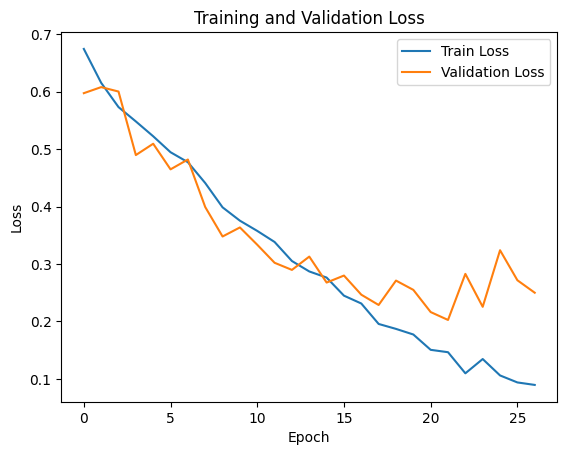

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Model Evaluation and Metrics Calculation

In [11]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()

all_preds = []
all_labels = []

# Run inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        outputs = model(images)


        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())   


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 90.41%
Precision: 0.9052
Recall: 0.9041
F1 Score: 0.9041


## 7. Transfer Learning Experiments
Transfer learning uses models pretrained on ImageNet. We replace the top layers with our own classifier to adapt them to our 4-class problem.

### ResNet50
A deep residual network effective in handling vanishing gradients.

In [12]:
import torchvision.models as models
from torch import nn

def get_transfer_model(model_name, num_classes):
    """Load a pre-trained model and modify its final layer for transfer learning."""
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)  # Load pre-trained ResNet50
        
        # Freeze all layers except the final layer
        for param in model.parameters():
            param.requires_grad = False
            
        # Replace the final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        return model
    else:
        raise ValueError(f"Model {model_name} not supported")

In [13]:
from tqdm import tqdm  
from torch.cuda.amp import autocast, GradScaler  

num_epochs = 50  

model = get_transfer_model('resnet50', num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()  

optimizer = optim.Adam(model.parameters(), lr=0.001)  

early_stopping = EarlyStopping(patience=5)  

train_losses, val_losses = [], []  

scaler = GradScaler()
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()  
    train_loss = 0  
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  

        optimizer.zero_grad()  

        with autocast(): 
            outputs = model(images)  
            loss = criterion(outputs, labels) 

        
        scaler.scale(loss).backward()  
        scaler.step(optimizer)  
        scaler.update()  
        train_loss += loss.item()

    
    model.eval() 
    val_loss = 0  
    with torch.no_grad(): 
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda') 
            with autocast():  
                outputs = model(images)  
                loss = criterion(outputs, labels)  
            val_loss += loss.item()  

    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



torch.save(model.state_dict(), 'transfer_learning_resnet50.pth')
print("Model saved as 'transfer_learning_resnet50.pth'")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s] 
/tmp/ipykernel_35/1434240759.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_35/1434240759.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/63 [00:00<?, ?it/s]         /tmp/ipykernel_35/1434240759.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.4843, Validation Loss: 0.4049
Epoch 2/50


Train Loss: 0.4018, Validation Loss: 0.3824
Epoch 3/50


Train Loss: 0.3899, Validation Loss: 0.3526
Epoch 4/50


Train Loss: 0.3990, Validation Loss: 0.3490
Epoch 5/50


Train Loss: 0.3602, Validation Loss: 0.3813
Epoch 6/50


Train Loss: 0.3654, Validation Loss: 0.4307
Epoch 7/50


Train Loss: 0.3506, Validation Loss: 0.3264
Epoch 8/50


Train Loss: 0.3322, Validation Loss: 0.3231
Epoch 9/50


Train Loss: 0.3411, Validation Loss: 0.3926
Epoch 10/50


Train Loss: 0.3249, Validation Loss: 0.3223
Epoch 11/50


Train Loss: 0.3361, Validation Loss: 0.3263
Epoch 12/50


Train Loss: 0.3287, Validation Loss: 0.3047
Epoch 13/50


Train Loss: 0.3286, Validation Loss: 0.3032
Epoch 14/50


Train Loss: 0.3209, Validation Loss: 0.3777
Epoch 15/50


Train Loss: 0.3040, Validation Loss: 0.3029
Epoch 16/50


Train Loss: 0.3087, Validation Loss: 0.3234
Epoch 17/50


Train Loss: 0.3173, Validation Loss: 0.3926
Epoch 18/50


Train Loss: 0.3111, Validation Loss: 0.2896
Epoch 19/50


Train Loss: 0.2996, Validation Loss: 0.2861
Epoch 20/50


Train Loss: 0.3015, Validation Loss: 0.2870
Epoch 21/50


Train Loss: 0.3058, Validation Loss: 0.4575
Epoch 22/50


Train Loss: 0.2896, Validation Loss: 0.2790
Epoch 23/50


Train Loss: 0.3144, Validation Loss: 0.3076
Epoch 24/50


Train Loss: 0.2906, Validation Loss: 0.2793
Epoch 25/50


Train Loss: 0.2924, Validation Loss: 0.2824
Epoch 26/50


Train Loss: 0.2895, Validation Loss: 0.2725
Epoch 27/50


Train Loss: 0.2806, Validation Loss: 0.2845
Epoch 28/50


Train Loss: 0.2722, Validation Loss: 0.2740
Epoch 29/50


Train Loss: 0.2948, Validation Loss: 0.2698
Epoch 30/50


Train Loss: 0.2843, Validation Loss: 0.2649
Epoch 31/50


Train Loss: 0.2642, Validation Loss: 0.2762
Epoch 32/50


Train Loss: 0.2649, Validation Loss: 0.3855
Epoch 33/50


Train Loss: 0.2760, Validation Loss: 0.3364
Epoch 34/50


Train Loss: 0.2654, Validation Loss: 0.3458
Epoch 35/50


Train Loss: 0.2736, Validation Loss: 0.2612
Epoch 36/50


Train Loss: 0.2726, Validation Loss: 0.3196
Epoch 37/50


Train Loss: 0.2587, Validation Loss: 0.2823
Epoch 38/50


Train Loss: 0.2664, Validation Loss: 0.2818
Epoch 39/50


Train Loss: 0.2653, Validation Loss: 0.2678
Epoch 40/50


Train Loss: 0.2817, Validation Loss: 0.2590
Epoch 41/50


Train Loss: 0.2727, Validation Loss: 0.2571
Epoch 42/50


Train Loss: 0.2430, Validation Loss: 0.2627
Epoch 43/50


Train Loss: 0.2589, Validation Loss: 0.3168
Epoch 44/50


Train Loss: 0.2574, Validation Loss: 0.2512
Epoch 45/50


Train Loss: 0.2807, Validation Loss: 0.2590
Epoch 46/50


Train Loss: 0.2549, Validation Loss: 0.2630
Epoch 47/50


Train Loss: 0.2464, Validation Loss: 0.2519
Epoch 48/50


Train Loss: 0.2482, Validation Loss: 0.2523
Epoch 49/50


Train Loss: 0.2573, Validation Loss: 0.2894
Early stopping triggered.
Model saved as 'transfer_learning_resnet50.pth'


## Plot Training History
Plot training and validation accuracy/loss across epochs. These plots help you:
- Monitor overfitting (if validation accuracy drops while training accuracy increases)
- Understand learning progress visually

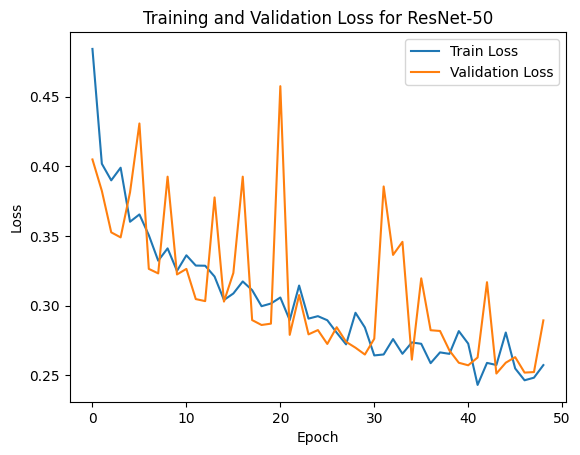

In [14]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for ResNet-50")
plt.show()

In [15]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 86.81%
Precision: 0.8892
Recall: 0.8681
F1 Score: 0.8665


###  EfficientNetB0

In [16]:
import torchvision.models as models
from torch import nn

def get_transfer_model(model_name, num_classes):
    """Load a pre-trained model and modify its final layer for transfer learning."""
    if model_name == 'efficientnet_b0':
        # Load pre-trained EfficientNet-B0 (updated syntax)
        model = models.efficientnet_b0(weights="DEFAULT")  # OR weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        
        # Freeze all layers except the classifier
        for param in model.parameters():
            param.requires_grad = False
            
        # Replace the final classification layer (EfficientNet uses classifier[1])
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        return model
    else:
        raise ValueError(f"Model {model_name} not supported")

In [17]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch

def get_transfer_model(model_name, num_classes):
    if model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights='DEFAULT')
        
       
        for param in model.parameters():
            param.requires_grad = False
            
        # Replace the final classification layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        return model
    else:
        raise ValueError(f"Model {model_name} not supported")


num_epochs = 50
num_classes = len(dataset.classes) 

model = get_transfer_model('efficientnet_b0', num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []
scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

torch.save(model.state_dict(), 'transfer_learning_efficientnet_b0.pth')
print("Model saved as 'transfer_learning_efficientnet_b0.pth'")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 
/tmp/ipykernel_35/167587461.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_35/167587461.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/63 [00:00<?, ?it/s]         /tmp/ipykernel_35/167587461.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.4854, Validation Loss: 0.3801
Epoch 2/50


Train Loss: 0.3938, Validation Loss: 0.3609
Epoch 3/50


Train Loss: 0.3675, Validation Loss: 0.3375
Epoch 4/50


Train Loss: 0.3560, Validation Loss: 0.3451
Epoch 5/50


Train Loss: 0.3482, Validation Loss: 0.3156
Epoch 6/50


Train Loss: 0.3484, Validation Loss: 0.3177
Epoch 7/50


Train Loss: 0.3496, Validation Loss: 0.3101
Epoch 8/50


Train Loss: 0.3484, Validation Loss: 0.3031
Epoch 9/50


Train Loss: 0.3505, Validation Loss: 0.3089
Epoch 10/50


Train Loss: 0.3433, Validation Loss: 0.3033
Epoch 11/50


Train Loss: 0.3488, Validation Loss: 0.3101
Epoch 12/50


Train Loss: 0.3373, Validation Loss: 0.2972
Epoch 13/50


Train Loss: 0.3426, Validation Loss: 0.3024
Epoch 14/50


Train Loss: 0.3459, Validation Loss: 0.3185
Epoch 15/50


Train Loss: 0.3412, Validation Loss: 0.2919
Epoch 16/50


Train Loss: 0.3352, Validation Loss: 0.3049
Epoch 17/50


Train Loss: 0.3425, Validation Loss: 0.3027
Epoch 18/50


Train Loss: 0.3423, Validation Loss: 0.3016
Epoch 19/50


Train Loss: 0.3413, Validation Loss: 0.3034
Epoch 20/50


Train Loss: 0.3459, Validation Loss: 0.2951
Early stopping triggered.
Model saved as 'transfer_learning_efficientnet_b0.pth'


## Plot Training History
Plot training and validation accuracy/loss across epochs. These plots help you:
- Monitor overfitting (if validation accuracy drops while training accuracy increases)
- Understand learning progress visually

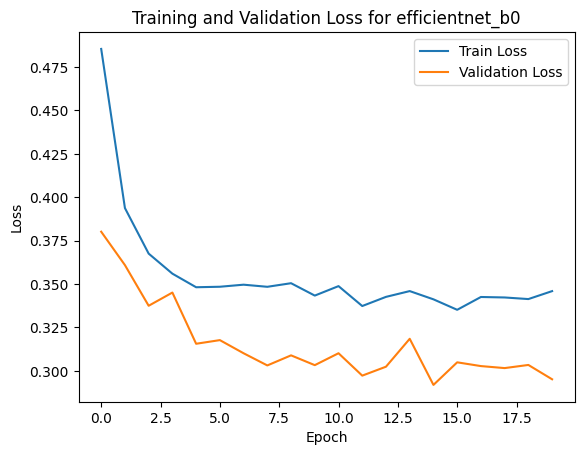

In [18]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for efficientnet_b0")
plt.show()

In [19]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 86.81%
Precision: 0.8683
Recall: 0.8681
F1 Score: 0.8681


## MobileNet V2

In [20]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

# Define get_transfer_model for MobileNetV2
def get_transfer_model(model_name, num_classes):
    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights='DEFAULT')
        
        # Freeze all layers except classifier
        for param in model.parameters():
            param.requires_grad = False
            
        # Replace the final classification layer
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        
        return model
    else:
        raise ValueError(f"Model {model_name} not supported")

# Set number of epochs and initialize variables
num_epochs = 50
num_classes = len(dataset.classes)  # Make sure dataset is defined

model = get_transfer_model('mobilenet_v2', num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []
val_accuracies = []
scaler = GradScaler()

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

# Save the model
torch.save(model.state_dict(), 'transfer_learning_mobilenet_v2.pth')
print("Model saved as 'transfer_learning_mobilenet_v2.pth'")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 89.1MB/s]
/tmp/ipykernel_35/688585714.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_35/688585714.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/63 [00:00<?, ?it/s]         /tmp/ipykernel_35/688585714.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.5207, Val Loss: 0.4381, Val Acc: 80.55%
Epoch 2/50


Train Loss: 0.4379, Val Loss: 0.4095, Val Acc: 80.80%
Epoch 3/50


Train Loss: 0.4131, Val Loss: 0.4014, Val Acc: 81.75%
Epoch 4/50


Train Loss: 0.3945, Val Loss: 0.3838, Val Acc: 83.30%
Epoch 5/50


Train Loss: 0.3890, Val Loss: 0.3680, Val Acc: 83.45%
Epoch 6/50


Train Loss: 0.3804, Val Loss: 0.3621, Val Acc: 83.15%
Epoch 7/50


Train Loss: 0.3749, Val Loss: 0.3662, Val Acc: 83.15%
Epoch 8/50


Train Loss: 0.3699, Val Loss: 0.3533, Val Acc: 83.90%
Epoch 9/50


Train Loss: 0.3700, Val Loss: 0.3516, Val Acc: 83.90%
Epoch 10/50


Train Loss: 0.3635, Val Loss: 0.3520, Val Acc: 83.65%
Epoch 11/50


Train Loss: 0.3619, Val Loss: 0.3525, Val Acc: 83.30%
Epoch 12/50


Train Loss: 0.3522, Val Loss: 0.3577, Val Acc: 83.20%
Epoch 13/50


Train Loss: 0.3590, Val Loss: 0.3456, Val Acc: 84.20%
Epoch 14/50


Train Loss: 0.3574, Val Loss: 0.3420, Val Acc: 84.20%
Epoch 15/50


Train Loss: 0.3478, Val Loss: 0.3409, Val Acc: 84.60%
Epoch 16/50


Train Loss: 0.3563, Val Loss: 0.3469, Val Acc: 84.25%
Epoch 17/50


Train Loss: 0.3509, Val Loss: 0.3333, Val Acc: 84.60%
Epoch 18/50


Train Loss: 0.3523, Val Loss: 0.3389, Val Acc: 84.30%
Epoch 19/50


Train Loss: 0.3534, Val Loss: 0.3441, Val Acc: 84.80%
Epoch 20/50


Train Loss: 0.3663, Val Loss: 0.3459, Val Acc: 83.95%
Epoch 21/50


Train Loss: 0.3558, Val Loss: 0.3286, Val Acc: 84.15%
Epoch 22/50


Train Loss: 0.3635, Val Loss: 0.3443, Val Acc: 84.00%
Epoch 23/50


Train Loss: 0.3626, Val Loss: 0.3463, Val Acc: 84.00%
Epoch 24/50


Train Loss: 0.3520, Val Loss: 0.3318, Val Acc: 84.65%
Epoch 25/50


Train Loss: 0.3646, Val Loss: 0.3405, Val Acc: 84.15%
Epoch 26/50


Train Loss: 0.3593, Val Loss: 0.3420, Val Acc: 84.00%
Early stopping triggered.
Model saved as 'transfer_learning_mobilenet_v2.pth'


## Plot Training History
Plot training and validation accuracy/loss across epochs. These plots help you:
- Monitor overfitting (if validation accuracy drops while training accuracy increases)
- Understand learning progress visually

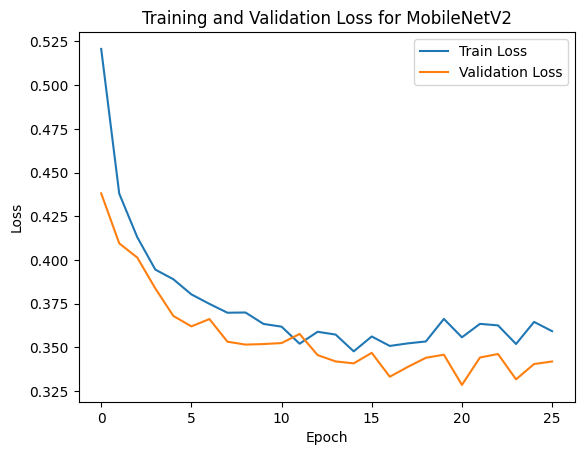

In [21]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for MobileNetV2")
plt.show()

In [22]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 83.42%
Precision: 0.8389
Recall: 0.8342
F1 Score: 0.8337


## VGG16

In [23]:
import torchvision.models as models
from torch import nn

def get_transfer_model(model_name, num_classes):
    """Load a pre-trained model and modify its final layer for transfer learning."""
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)  # Load pre-trained ResNet50
        
        # Freeze all layers except the final layer
        for param in model.parameters():
            param.requires_grad = False
            
        # Replace the final fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        return model
    else:
        raise ValueError(f"Model {model_name} not supported")

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# Initialize VGG16 with updated torchvision syntax
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier for your number of classes
# VGG16's classifier is a sequence of Linear and ReLU layers
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, num_classes)  # Replace last layer

# Move model to GPU
model = model.to('cuda')

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - only for unfrozen parameters (the last layer by default)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []
scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    model.train()
    train_loss = 0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

torch.save(model.state_dict(), 'vgg16_transfer_learning.pth')
print("Model saved as 'vgg16_transfer_learning.pth'")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 209MB/s] 
/tmp/ipykernel_35/4159767810.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_35/4159767810.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/63 [00:00<?, ?it/s]         /tmp/ipykernel_35/4159767810.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 0.6386, Validation Loss: 0.5720
Epoch 2/50


Train Loss: 0.5756, Validation Loss: 0.5394
Epoch 3/50


Train Loss: 0.5478, Validation Loss: 0.5184
Epoch 4/50


Train Loss: 0.5334, Validation Loss: 0.5072
Epoch 5/50


Train Loss: 0.5238, Validation Loss: 0.4994
Epoch 6/50


Train Loss: 0.5142, Validation Loss: 0.4863
Epoch 7/50


Train Loss: 0.5128, Validation Loss: 0.4825
Epoch 8/50


Train Loss: 0.5032, Validation Loss: 0.4729
Epoch 9/50


Train Loss: 0.5006, Validation Loss: 0.4690
Epoch 10/50


Train Loss: 0.4937, Validation Loss: 0.4649
Epoch 11/50


Train Loss: 0.4861, Validation Loss: 0.4611
Epoch 12/50


Train Loss: 0.4871, Validation Loss: 0.4613
Epoch 13/50


Train Loss: 0.4830, Validation Loss: 0.4522
Epoch 14/50


Train Loss: 0.4794, Validation Loss: 0.4492
Epoch 15/50


Train Loss: 0.4834, Validation Loss: 0.4499
Epoch 16/50


Train Loss: 0.4745, Validation Loss: 0.4440
Epoch 17/50


Train Loss: 0.4736, Validation Loss: 0.4425
Epoch 18/50


Train Loss: 0.4734, Validation Loss: 0.4511
Epoch 19/50


Train Loss: 0.4704, Validation Loss: 0.4401
Epoch 20/50


Train Loss: 0.4668, Validation Loss: 0.4360
Epoch 21/50


Train Loss: 0.4655, Validation Loss: 0.4333
Epoch 22/50


Train Loss: 0.4662, Validation Loss: 0.4338
Epoch 23/50


Train Loss: 0.4651, Validation Loss: 0.4379
Epoch 24/50


Train Loss: 0.4660, Validation Loss: 0.4310
Epoch 25/50


Train Loss: 0.4671, Validation Loss: 0.4340
Epoch 26/50


Train Loss: 0.4598, Validation Loss: 0.4283
Epoch 27/50


Train Loss: 0.4639, Validation Loss: 0.4291
Epoch 28/50


Train Loss: 0.4615, Validation Loss: 0.4258
Epoch 29/50


Train Loss: 0.4559, Validation Loss: 0.4232
Epoch 30/50


Train Loss: 0.4534, Validation Loss: 0.4229
Epoch 31/50


Train Loss: 0.4528, Validation Loss: 0.4217
Epoch 32/50


Train Loss: 0.4571, Validation Loss: 0.4224
Epoch 33/50


Train Loss: 0.4670, Validation Loss: 0.4203
Epoch 34/50


Train Loss: 0.4548, Validation Loss: 0.4199
Epoch 35/50


Train Loss: 0.4484, Validation Loss: 0.4193
Epoch 36/50


Train Loss: 0.4579, Validation Loss: 0.4191
Epoch 37/50


Train Loss: 0.4547, Validation Loss: 0.4230
Epoch 38/50


Train Loss: 0.4498, Validation Loss: 0.4192
Epoch 39/50


Train Loss: 0.4553, Validation Loss: 0.4161
Epoch 40/50


Train Loss: 0.4565, Validation Loss: 0.4176
Epoch 41/50


Train Loss: 0.4529, Validation Loss: 0.4146
Epoch 42/50


Train Loss: 0.4504, Validation Loss: 0.4135
Epoch 43/50


Train Loss: 0.4563, Validation Loss: 0.4128
Epoch 44/50


Train Loss: 0.4463, Validation Loss: 0.4168
Epoch 45/50


Train Loss: 0.4533, Validation Loss: 0.4132
Epoch 46/50


Train Loss: 0.4521, Validation Loss: 0.4116
Epoch 47/50


Train Loss: 0.4547, Validation Loss: 0.4179
Epoch 48/50


Train Loss: 0.4452, Validation Loss: 0.4116
Epoch 49/50


Train Loss: 0.4477, Validation Loss: 0.4113
Epoch 50/50


Train Loss: 0.4560, Validation Loss: 0.4112
Model saved as 'vgg16_transfer_learning.pth'


## Plot Training History
Plot training and validation accuracy/loss across epochs. These plots help you:
- Monitor overfitting (if validation accuracy drops while training accuracy increases)
- Understand learning progress visually

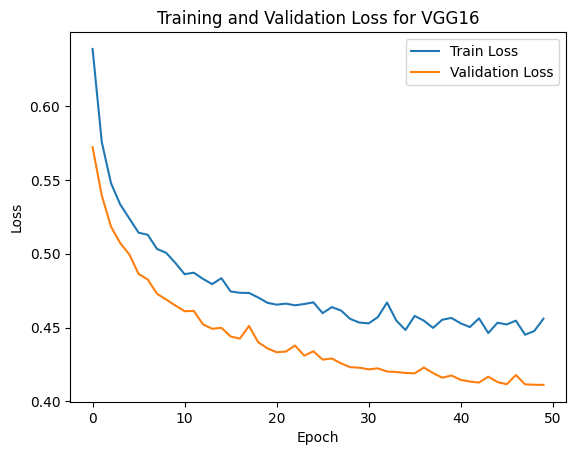

In [25]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for VGG16")
plt.show()

In [26]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Move model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Run inference
with torch.no_grad():  # Disable gradient calculation for faster inference
    for images, labels in test_loader:
        # Move images and labels to the same device as the model (GPU)
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)

        # Get predictions (choose the class with the highest logit score)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels to lists
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Move to CPU and convert to numpy

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 80.12%
Precision: 0.8080
Recall: 0.8012
F1 Score: 0.8003


## XAI - Grad-CAM, Grad-CAM++, Eigen-CAM

**1. Grad-CAM (Gradient-weighted Class Activation Mapping)**
Grad-CAM uses gradients flowing back from a target class to the last convolutional layer of a model to generate a heatmap. This heatmap highlights the areas in the image that are most relevant to the model's classification for a particular class.

* **How It Works:** Grad-CAM computes the gradients of the target class score concerning the feature maps of a convolutional layer. These gradients are globally pooled to get a single weight for each feature map. Then, each feature map is multiplied by its corresponding weight, and all feature maps are summed up. Finally, ReLU is applied to keep only the positive influences.
* **Interpretation:** The resulting heatmap shows which regions contribute positively to the model's confidence for the specified class. This approach is class-discriminative, meaning it highlights areas of the image that correspond specifically to the predicted class.

**2. Grad-CAM++**
Grad-CAM++ is an extension of Grad-CAM that refines the heatmap to provide more detailed localization, especially in cases where multiple objects are present or when the object of interest is not dominant in the image.

* **How It Works:** Grad-CAM++ introduces additional weighting terms to account for each pixel's importance in the feature maps. It calculates pixel-wise weights rather than global weights for each feature map. These pixel-wise weights are derived from higher-order gradients, allowing Grad-CAM++ to better capture complex and subtle details in an image.
* **Interpretation:** Grad-CAM++ often produces sharper, more localized heatmaps, which can be especially useful in medical imaging, fine-grained classification, or images with multiple objects of interest.

**3. Eigen-CAM**
Eigen-CAM is a technique based on Principal Component Analysis (PCA) of the feature maps, rather than using gradients, to produce a heatmap. It’s an unsupervised approach that doesn’t depend on any specific target class and is class-agnostic.

* **How It Works:** Eigen-CAM applies PCA to the feature maps from a chosen convolutional layer. It uses the principal eigenvector of these feature maps to identify regions of high variance, which often correlate with regions that the model finds significant for any class. The resulting heatmap highlights the parts of the image that contribute most to the model’s general activations, rather than to a specific class.
* **Interpretation:** Since it’s class-agnostic, Eigen-CAM is ideal for understanding the general features in an image that activate a model, regardless of class. This is useful for cases where we want to understand model behavior without biasing it toward a particular prediction.


In [28]:
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Load the fine-tuned ResNet-50 model
num_classes = len(dataset.classes)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("transfer_learning_resnet50.pth", weights_only=True))  # Safer loading
model = model.to('cuda')
model.eval()  # Set model to evaluation mode

# Select a sample image from the test dataset
sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

# Convert sample image to numpy for visualization
original_image_np = sample_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5  # Unnormalize
original_image_np = np.clip(original_image_np, 0, 1)

# Set up Grad-CAM, Grad-CAM++, and Eigen-CAM
target_layers = [model.layer4[-1]]  # Last layer of ResNet-50

# Initialize CAM methods
gradcam = GradCAM(model=model, target_layers=target_layers)
gradcam_plus_plus = GradCAMPlusPlus(model=model, target_layers=target_layers)
eigen_cam = EigenCAM(model=model, target_layers=target_layers)

# Run inference to get the predicted class
with torch.no_grad():
    outputs = model(sample_image)
    predicted_class = outputs.argmax().item()
    predicted_class_name = class_names[predicted_class]  # Ensure `class_names` is defined

# Define the target class for CAM methods
target = [ClassifierOutputTarget(predicted_class)]

# Generate heatmaps
gradcam_heatmap = gradcam(input_tensor=sample_image, targets=target)[0]
gradcam_pp_heatmap = gradcam_plus_plus(input_tensor=sample_image, targets=target)[0]
eigen_cam_heatmap = eigen_cam(input_tensor=sample_image, targets=target)[0]

# Overlay the heatmaps on the original image
gradcam_result = show_cam_on_image(original_image_np, gradcam_heatmap, use_rgb=True)
gradcam_pp_result = show_cam_on_image(original_image_np, gradcam_pp_heatmap, use_rgb=True)
eigen_cam_result = show_cam_on_image(original_image_np, eigen_cam_heatmap, use_rgb=True)

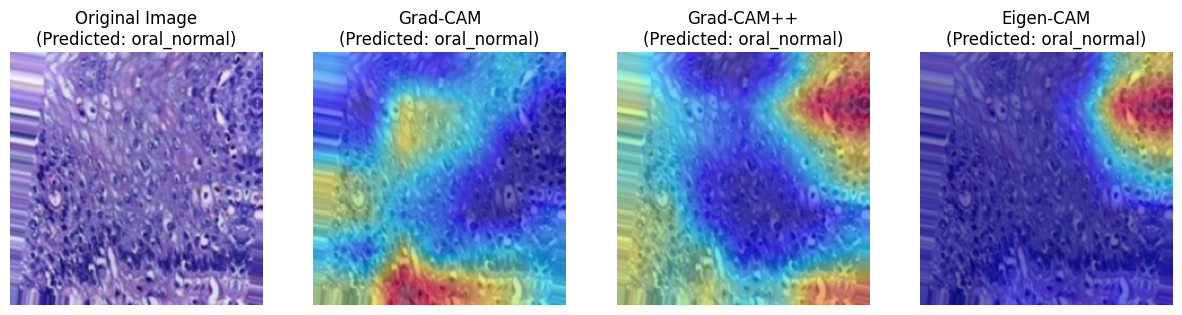

In [29]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(original_image_np)
plt.title(f"Original Image\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(gradcam_result)
plt.title(f"Grad-CAM\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(gradcam_pp_result)
plt.title(f"Grad-CAM++\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(eigen_cam_result)
plt.title(f"Eigen-CAM\n(Predicted: {predicted_class_name})")
plt.axis("off")

plt.show()

## LIME

**Purpose:** LIME explains a model’s prediction for a specific image by highlighting important regions that influenced the prediction.

**How Users Can Understand the Classification Output with LIME:**

**Highlighted Regions:** LIME’s heatmap shows which parts of the image were most important to the model’s decision. Brighter or colored areas on the heatmap indicate regions that strongly support the model's prediction.
**Interpretation:** By viewing these highlighted regions, users can understand what the model "focused on" to make its prediction. For example, if a model predicts "dog" and LIME highlights the face and body, it indicates these parts were most relevant to the model’s decision.

  0%|          | 0/100 [00:00<?, ?it/s]

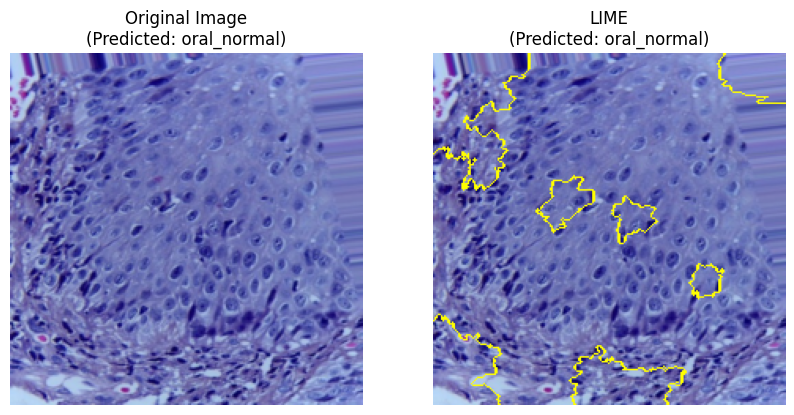

In [30]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image


num_classes = len(dataset.classes)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("transfer_learning_resnet50.pth"))
model = model.to('cuda')
model.eval()

sample_image, _ = dataset[0]  
original_image_np = sample_image.permute(1, 2, 0).cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5  
original_image_np = np.clip(original_image_np, 0, 1) 

def batch_predict(images):
    model.eval()
    batch = torch.stack([transform_test(Image.fromarray((image * 255).astype(np.uint8))) for image in images], dim=0).to('cuda')
    with torch.no_grad():
        logits = model(batch)
    return logits.cpu().numpy()


explainer = lime_image.LimeImageExplainer()


lime_explanation = explainer.explain_instance(
    original_image_np,  
    batch_predict,      
    top_labels=1,      
    hide_color=0,
    num_samples=100    
)

predicted_class = model(sample_image.unsqueeze(0).to('cuda')).argmax().item()
lime_image, lime_mask = lime_explanation.get_image_and_mask(
    label=predicted_class,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)
lime_image = mark_boundaries(lime_image, lime_mask)

# Display the original and LIME result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title(f"Original Image\n(Predicted: {class_names[predicted_class]})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lime_image)
plt.title(f"LIME\n(Predicted: {class_names[predicted_class]})")
plt.axis("off")

plt.show()

## 9.Conclusion & Future Work
This project successfully shows how image classification techniques using CNNs and transfer learning can detect disease or quality status in dragon fruits and leaves.

🔮 **Future Improvements:**
- Tune learning rates, batch sizes, dropout rates
- Evaluate performance using confusion matrix, precision, recall, and F1 score
- Add real-time inference and deployment via a web or mobile app
- Use Grad-CAM to visually interpret which regions influenced the prediction most